## - TensorFlow Eager Execution

## - Focal Loss for Imbalanced Data

### Library

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection  import train_test_split
from sklearn import metrics

import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(0)

### Eager execution

In [2]:
tf.enable_eager_execution()

In [3]:
print ("TensorFlow version: {}".format(tf.VERSION))
print ("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.13.1
Eager execution: True


### Data

In [4]:
cwd = os.getcwd()

path = os.path.join(cwd, 'data')
file = 'PS_20174392719_1491204439457_log.csv'

In [5]:
df_data = pd.read_csv(os.path.join(path, file))

print ('shape: ', df_data.shape)
df_data.head()

shape:  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df_data = df_data.drop('nameDest', axis=1)
df_data = df_data.drop('nameOrig', axis=1)
df_data = df_data.drop('type', axis=1)

print ('shape: ', df_data.shape)
df_data.head()

shape:  (6362620, 8)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


0    6354407
1       8213
Name: isFraud, dtype: int64

% of 0:  0.9987091795518198


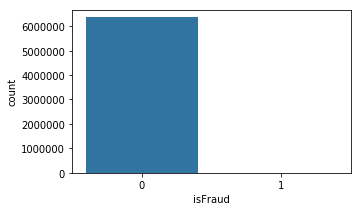

In [7]:
print (df_data['isFraud'].value_counts())
print ()
print ('% of 0: ', np.sum(df_data['isFraud']==0)/len(df_data))

plt.figure(figsize=(5, 3))
sns.countplot(df_data['isFraud'])
plt.show()

In [8]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [27]:
X, y = df_data.iloc[:,:-2], df_data.iloc[:, -2]
y = tf.keras.utils.to_categorical(y, num_classes=2)

print ('shape of X: ', X.shape)
print ('shape of y: ', y.shape)

shape of X:  (6362620, 6)
shape of y:  (6362620, 2)


In [28]:
X = feature_normalize(X.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print ('shape of X_train: ', X_train.shape)
print ('shape of y_test: ', y_test.shape)

shape of X_train:  (5090096, 6)
shape of y_test:  (1272524, 2)


In [29]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

### Models

#### Pattern 1

In [12]:
class Pattern1():        
    def __init__(self):        
        input_size = X_train.shape[1]
        hidden_size1 = 10
        hidden_size2 = 20
        hidden_size3 = 10
        output_size = y_train.shape[1]
        
        self.fc1_w = tfe.Variable(tf.truncated_normal([input_size, hidden_size1],
                                                       stddev=0.1), dtype=tf.float32)
        self.fc1_b = tfe.Variable(tf.constant(0.1, shape=[hidden_size1]),
                                  dtype=tf.float32)
        self.fc2_w = tfe.Variable(tf.truncated_normal([hidden_size1, hidden_size2],
                                                      stddev=0.1), dtype=tf.float32)
        self.fc2_b = tfe.Variable(tf.constant(0.1, shape=[hidden_size2]),
                                  dtype=tf.float32)
        self.fc3_w = tfe.Variable(tf.truncated_normal([hidden_size2, hidden_size3], 
                                                      stddev=0.1), dtype=tf.float32)
        self.fc3_b = tfe.Variable(tf.constant(0.1, shape=[hidden_size3]), 
                                  dtype=tf.float32)
        self.fc4_w = tfe.Variable(tf.truncated_normal([hidden_size3, output_size], 
                                                      stddev=0.1), dtype=tf.float32)
        self.fc4_b = tfe.Variable(tf.constant(0.1, shape=[output_size]), 
                                  dtype=tf.float32)        
        self.variables = [
            self.fc1_w, self.fc1_b,
            self.fc2_w, self.fc2_b,
            self.fc3_w, self.fc3_b,
            self.fc4_w, self.fc4_b,
        ]
        
    def __call__(self, x):
        h = tf.nn.relu(tf.matmul(x, self.fc1_w) + self.fc1_b)
        h = tf.nn.relu(tf.matmul(h, self.fc2_w) + self.fc2_b)
        h = tf.nn.relu(tf.matmul(h, self.fc3_w) + self.fc3_b)
        y_pred = tf.matmul(h, self.fc4_w) + self.fc4_b
        return y_pred

In [31]:
model = Pattern1()

model(X_test_tf[:1])

<tf.Tensor: id=2370255, shape=(1, 2), dtype=float32, numpy=array([[0.1124927 , 0.12200893]], dtype=float32)>

#### Pattern 2

In [13]:
class Pattern2(tf.keras.Model):
    def __init__(self):
        super(Pattern2, self).__init__()
        
        input_shape = X_train.shape[1:]
        hidden_size1 = 10
        hidden_size2 = 20
        hidden_size3 = 10
        output_size = y_train.shape[1]
        
        self.dense1 = tf.keras.layers.Dense(hidden_size1, activation='relu',
                                           input_shape=input_shape)
        self.dense2 = tf.keras.layers.Dense(hidden_size2, activation='relu')
        self.dense3 = tf.keras.layers.Dense(hidden_size3, activation='relu')
        self.dense4 = tf.keras.layers.Dense(output_size, activation='softmax')
        
    def __call__(self, x):
        h = self.dense1(x)
        h = self.dense2(h)
        h = self.dense3(h)
        h = self.dense4(h)
        return h

In [32]:
model = Pattern2()

model(X_train_tf[:1, :])

<tf.Tensor: id=2370368, shape=(1, 2), dtype=float32, numpy=array([[0.5131002, 0.4868998]], dtype=float32)>

In [114]:
#model.summary()

#### Pattern 3

In [33]:
input_shape = X_train.shape[1:]
hidden_size1 = 10
hidden_size2 = 20
hidden_size3 = 10
output_size = y_train.shape[1]

Pattern3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_size1, activation='relu'),
    tf.keras.layers.Dense(hidden_size2, activation='relu'),
    tf.keras.layers.Dense(hidden_size3, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax'),    
])

In [34]:
Pattern3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_13 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


### Training

#### Pattern 1

In [61]:
model = Pattern3

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [62]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', 
                               patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', 
                              factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 3
batch_size = 1000

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2,                    
                    )

Train on 5090096 samples, validate on 1272524 samples
Epoch 1/3
 - 12s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 0.9994
Epoch 2/3
 - 12s - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 3/3
 - 12s - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0031 - val_acc: 0.9993


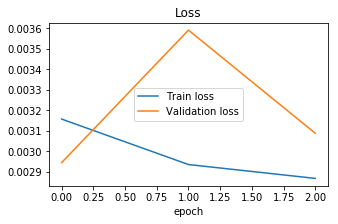

In [63]:
plt.figure(figsize=(5, 3))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

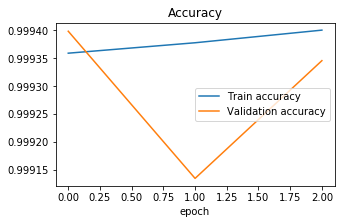

In [64]:
plt.figure(figsize=(5, 3))
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

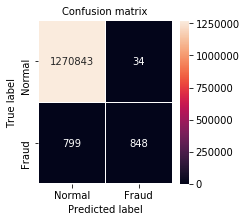

In [65]:
preds = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

truth = np.argmax(y_test, axis=1)
predictions = np.argmax(preds, axis=1)
confusion_matrix = metrics.confusion_matrix(truth, predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS,
            annot=True, fmt="d", linewidth=0.1, linecolor='white', 
            annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [66]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)

f1 = metrics.f1_score(truth, predictions)
precision = metrics.precision_score(truth, predictions)
recall = metrics.recall_score(truth, predictions)

print ('error count: ', error_count)
print ('f1: {:.3f}'.format(f1))
print ('precision: {:.3f}'.format(precision))
print ('recall: {:.3f}'.format(recall))

error count:  833
f1: 0.671
precision: 0.961
recall: 0.515


#### Pattern 2

In [40]:
model = Pattern3

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
class_weight = {0 : 1., 1: 20.}

epochs = 3
batch_size = 1000

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight,
                    verbose=2,                    
                    )

Train on 5090096 samples, validate on 1272524 samples
Epoch 1/3
 - 12s - loss: 0.0416 - acc: 0.9984 - val_loss: 0.0210 - val_acc: 0.9965
Epoch 2/3
 - 13s - loss: 0.0356 - acc: 0.9981 - val_loss: 0.0099 - val_acc: 0.9981
Epoch 3/3
 - 12s - loss: 0.0324 - acc: 0.9982 - val_loss: 0.0081 - val_acc: 0.9988


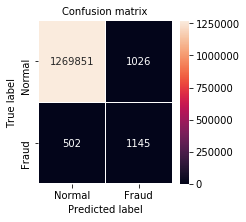

In [42]:
preds = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

truth = np.argmax(y_test, axis=1)
predictions = np.argmax(preds, axis=1)
confusion_matrix = metrics.confusion_matrix(truth, predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS,
            annot=True, fmt="d", linewidth=0.1, linecolor='white', 
            annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [43]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)

f1 = metrics.f1_score(truth, predictions)
precision = metrics.precision_score(truth, predictions)
recall = metrics.recall_score(truth, predictions)

print ('error count: ', error_count)
print ('f1: {:.3f}'.format(f1))
print ('precision: {:.3f}'.format(precision))
print ('recall: {:.3f}'.format(recall))

error count:  1528
f1: 0.600
precision: 0.527
recall: 0.695


#### Pattern 3

In [57]:
def loss(model, x, y):
    y_pred = model(x)
    cross_entropy = - tf.reduce_mean(tf.reduce_sum(y*tf.log(tf.clip_by_value(y_pred, 1e-10, 1.0)),
                                                   axis=1))
    return cross_entropy

def accuracy(y_true, y_pred):
    correct_preds = tf.equal(tf.argmax(y_true, axis = 1),
                             tf.argmax(y_pred, axis = 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    return accuracy
 
def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y)
    return tape.gradient(loss_value, model.variables)

In [58]:
model = Pattern2()

epochs = 3
batch_size = 1000
 
optimizer = tf.train.AdamOptimizer()
 
for epoch in tqdm(range(epochs)):
    
    n = tf.shape(X_train_tf).numpy()[0]
    perm = np.random.permutation(n)
    
    for i in range(0, n, batch_size): 
        batch_x = tf.gather(X_train_tf, perm[i:i+batch_size])
        batch_y = tf.gather(y_train_tf, perm[i:i+batch_size])
 
        grads = grad(model, batch_x, batch_y)
        optimizer.apply_gradients(zip(grads, model.variables), 
                                  global_step=tf.train.get_or_create_global_step())
 
    train_loss = loss(model, X_train_tf, y_train_tf)
    train_acc = accuracy(y_train_tf, model(X_train_tf))
    
    valid_loss = loss(model, X_test_tf, y_test_tf)
    valid_acc = accuracy(y_test_tf, model(X_test_tf))
     
    if (epoch+1)%1 == 0:
        tqdm.write('epoch:\t{}\tloss:\t{:.5f}\tacc:\t{:.5f}\tval_loss:\t{:.5f}\tval_acc:\t{:.5f}'.format(
            epoch+1, train_loss, train_acc, valid_loss, valid_acc)
                  )

epoch:	1	loss:	0.00451	acc:	0.99920	val_loss:	0.00461	val_acc:	0.99919


epoch:	2	loss:	0.00350	acc:	0.99929	val_loss:	0.00352	val_acc:	0.99929


epoch:	3	loss:	0.00310	acc:	0.99934	val_loss:	0.00314	val_acc:	0.99932


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:07<00:00, 22.41s/it]


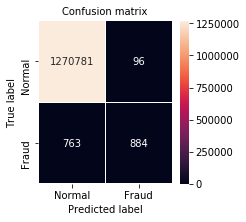

In [59]:
preds = model(X_test_tf)

LABELS = ['Normal','Fraud'] 

truth = np.argmax(y_test_tf, axis=1)
predictions = np.argmax(preds, axis=1)
confusion_matrix = metrics.confusion_matrix(truth, predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS,
            annot=True, fmt="d", linewidth=0.1, linecolor='white', 
            annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [60]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)

f1 = metrics.f1_score(truth, predictions)
precision = metrics.precision_score(truth, predictions)
recall = metrics.recall_score(truth, predictions)

print ('error count: ', error_count)
print ('f1: {:.3f}'.format(f1))
print ('precision: {:.3f}'.format(precision))
print ('recall: {:.3f}'.format(recall))

error count:  859
f1: 0.673
precision: 0.902
recall: 0.537


#### Pattern 4

In [51]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [53]:
model = Pattern3

model.compile(loss=focal_loss(alpha=1),
              optimizer='adam',
              metrics=['accuracy'])

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', 
                               patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', 
                              factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 3
batch_size = 1000

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2,                    
                    )

Train on 5090096 samples, validate on 1272524 samples
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/3
 - 12s - loss: 0.0010 - acc: 0.9993 - val_loss: 9.2969e-04 - val_acc: 0.9994
Epoch 2/3
 - 11s - loss: 9.6734e-04 - acc: 0.9994 - val_loss: 0.0011 - val_acc: 0.9993
Epoch 3/3
 - 13s - loss: 9.4486e-04 - acc: 0.9994 - val_loss: 9.1001e-04 - val_acc: 0.9994


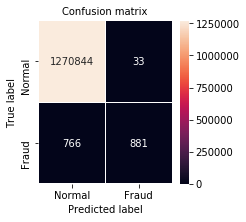

In [55]:
preds = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

truth = np.argmax(y_test, axis=1)
predictions = np.argmax(preds, axis=1)
confusion_matrix = metrics.confusion_matrix(truth, predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS,
            annot=True, fmt="d", linewidth=0.1, linecolor='white', 
            annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [56]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)

f1 = metrics.f1_score(truth, predictions)
precision = metrics.precision_score(truth, predictions)
recall = metrics.recall_score(truth, predictions)

print ('error count: ', error_count)
print ('f1: {:.3f}'.format(f1))
print ('precision: {:.3f}'.format(precision))
print ('recall: {:.3f}'.format(recall))

error count:  799
f1: 0.688
precision: 0.964
recall: 0.535


#### Pattern 5

In [67]:
def ce_loss(model, x, y):
    y_pred = model(x)
    cross_entropy = - tf.reduce_mean(tf.reduce_sum(y*tf.log(tf.clip_by_value(y_pred, 1e-10, 1.0)),
                                                   axis=1))
    return cross_entropy

def focal_loss(model, x, y, gamma=2., alpha=4.):
    epsilon = 1.e-9
    y_true = tf.convert_to_tensor(y, tf.float32)
    y_pred = tf.convert_to_tensor(model(x), tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def accuracy(y_true, y_pred):
    correct_preds = tf.equal(tf.argmax(y_true, axis = 1),
                             tf.argmax(y_pred, axis = 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    return accuracy
 
def grad(model, loss, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y)
    return tape.gradient(loss_value, model.variables)

In [73]:
model = Pattern2()
loss = focal_loss
epochs = 3
batch_size = 1000
 
optimizer = tf.train.AdamOptimizer()
 
for epoch in tqdm(range(epochs)):
    
    n = tf.shape(X_train_tf).numpy()[0]
    perm = np.random.permutation(n)
    
    for i in range(0, n, batch_size): 
        batch_x = tf.gather(X_train_tf, perm[i:i+batch_size])
        batch_y = tf.gather(y_train_tf, perm[i:i+batch_size])
 
        grads = grad(model, loss, batch_x, batch_y)
        optimizer.apply_gradients(zip(grads, model.variables), 
                                  global_step=tf.train.get_or_create_global_step())
 
    train_loss = loss(model, X_train_tf, y_train_tf)
    train_acc = accuracy(y_train_tf, model(X_train_tf))
    
    valid_loss = loss(model, X_test_tf, y_test_tf)
    valid_acc = accuracy(y_test_tf, model(X_test_tf))
     
    if (epoch+1)%1 == 0:
        tqdm.write('epoch:\t{}\tloss:\t{:.5f}\tacc:\t{:.5f}\tval_loss:\t{:.5f}\tval_acc:\t{:.5f}'.format(
            epoch+1, train_loss, train_acc, valid_loss, valid_acc)
                  )

epoch:	1	loss:	0.00518	acc:	0.99926	val_loss:	0.00527	val_acc:	0.99926


epoch:	2	loss:	0.00447	acc:	0.99932	val_loss:	0.00454	val_acc:	0.99930


epoch:	3	loss:	0.00407	acc:	0.99934	val_loss:	0.00410	val_acc:	0.99931


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:15<00:00, 25.57s/it]


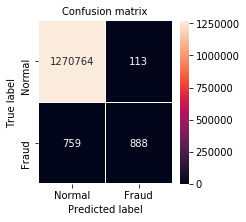

In [74]:
preds = model(X_test_tf)

LABELS = ['Normal','Fraud'] 

truth = np.argmax(y_test_tf, axis=1)
predictions = np.argmax(preds, axis=1)
confusion_matrix = metrics.confusion_matrix(truth, predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS,
            annot=True, fmt="d", linewidth=0.1, linecolor='white', 
            annot_kws={"size": 10});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()